<a href="https://colab.research.google.com/github/tspn/Covid19Forecasting/blob/main/Border2nd_WhoTransmissionType_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-learn==0.24

     |████████████████████████████████| 22.2MB 54.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
IntervalDays = 50
MovingAverageWindow = IntervalDays
PredictionTargetDay = 14
rollingTime = 5
CumulativeCases = "Cumulative_cases"
NewCases = "New_cases"
NormalizedCumulativeCases = "Normalized_cumulative_cases"
NormalizedNewCases = "Normalized_new_cases"
NormalizedMovingAvgCumulativeCases = "Normalized_MA_cumulative_cases"
NormalizedMovingAvgNewCases = "Normalized_MA_new_cases"

PredictionTargetDay = PredictionTargetDay - 1 

In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MAPE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from statistics import mean
from keras.callbacks import EarlyStopping
plt.rcParams['figure.figsize'] = [32, 12]

In [5]:
df = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv', skipinitialspace=True)
df.set_index('Date_reported', inplace=True)
df = df[df["Country"].isin(df[df["Cumulative_cases"] > 10000]["Country"].unique())]
df = df[df["Country"].isin(df[df["New_cases"] > 400]["Country"].unique())]
df = df[~df["Country"].isin(df[df["New_cases"] < 0]["Country"].unique())]
# df = df.drop(["2021-02-20"])
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0
2020-01-04,AL,Albania,EURO,0,0,0,0
2020-01-05,AL,Albania,EURO,0,0,0,0
2020-01-06,AL,Albania,EURO,0,0,0,0
2020-01-07,AL,Albania,EURO,0,0,0,0
...,...,...,...,...,...,...,...
2021-02-16,ZW,Zimbabwe,AFRO,50,35222,10,1410
2021-02-17,ZW,Zimbabwe,AFRO,93,35315,4,1414
2021-02-18,ZW,Zimbabwe,AFRO,108,35423,4,1418


In [6]:
dtdf = pd.read_csv("https://covid19.who.int/WHO-COVID-19-global-table-data.csv")
dtdf

,Name,WHO Region,Cases - cumulative total,Cases - cumulative total per 100000 population,Cases - newly reported in last 7 days,Cases - newly reported in last 7 days per 100000 population,Cases - newly reported in last 24 hours,Deaths - cumulative total,Deaths - cumulative total per 100000 population,Deaths - newly reported in last 7 days,Deaths - newly reported in last 7 days per 100000 population,Deaths - newly reported in last 24 hours,Transmission Classification
0,Global,NaN,110384747,1414.045018,2488467,31.877632,381841,2446008,31.333726,70588,0.904243,10715,NaN
1,United States of America,Americas,27628834,8347.010000,506251,152.940000,68191,489351,147.840000,17716,5.350000,2381,Community transmission
2,India,South-East Asia,10977387,795.460000,84641,6.130000,13993,156212,11.320000,662,0.050000,101,Clusters of cases
3,Brazil,Americas,10030626,4718.980000,316717,149.000000,51879,243457,114.540000,7256,3.410000,1367,Community transmission
4,Russian Federation,Europe,4151984,2845.100000,94286,64.610000,12953,82876,56.790000,3180,2.180000,480,Clusters of cases
...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,Saint Helena,Africa,0,0.000000,0,0.000000,0,0,0.000000,0,0.000000,0,No cases
234,Tokelau,Western Pacific,0,0.000000,0,0.000000,0,0,0.000000,0,0.000000,0,No cases
235,Tonga,Western Pacific,0,0.000000,0,0.000000,0,0,0.000000,0,0.000000,0,No cases
236,Turkmenistan,Europe,0,0.000000,0,0.000000,0,0,0.000000,0,0.000000,0,No cases


In [7]:
dtdf["Transmission Classification"].unique()

array([nan, 'Community transmission', 'Clusters of cases',
       'Sporadic cases', 'Pending', 'Not applicable', 'No cases'],
      dtype=object)

In [8]:
cumulativeScaler = StandardScaler()
cumulativeScaler.fit(df[CumulativeCases].values.reshape(-1, 1))
df[NormalizedCumulativeCases] = cumulativeScaler.transform(df[CumulativeCases].values.reshape(-1, 1)).flatten()
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases
Date_reported,,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0,-0.203387
2020-01-04,AL,Albania,EURO,0,0,0,0,-0.203387
2020-01-05,AL,Albania,EURO,0,0,0,0,-0.203387
2020-01-06,AL,Albania,EURO,0,0,0,0,-0.203387
2020-01-07,AL,Albania,EURO,0,0,0,0,-0.203387
...,...,...,...,...,...,...,...,...
2021-02-16,ZW,Zimbabwe,AFRO,50,35222,10,1410,-0.175725
2021-02-17,ZW,Zimbabwe,AFRO,93,35315,4,1414,-0.175652
2021-02-18,ZW,Zimbabwe,AFRO,108,35423,4,1418,-0.175567


In [9]:
newCasesScaler = StandardScaler()
newCasesScaler.fit(df[NewCases].values.reshape(-1, 1))
df[NormalizedNewCases] = cumulativeScaler.transform(df[NewCases].values.reshape(-1, 1)).flatten()
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases
Date_reported,,,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387
2020-01-04,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387
2020-01-05,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387
2020-01-06,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387
2020-01-07,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387
...,...,...,...,...,...,...,...,...,...
2021-02-16,ZW,Zimbabwe,AFRO,50,35222,10,1410,-0.175725,-0.203347
2021-02-17,ZW,Zimbabwe,AFRO,93,35315,4,1414,-0.175652,-0.203314
2021-02-18,ZW,Zimbabwe,AFRO,108,35423,4,1418,-0.175567,-0.203302


In [10]:
for country in df["Country"].unique():
  df.loc[df["Country"] == country, [NormalizedMovingAvgCumulativeCases]] = df[df["Country"] == country][NormalizedCumulativeCases].rolling(rollingTime).mean().values 
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases,Normalized_MA_cumulative_cases
Date_reported,,,,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,NaN
2020-01-04,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,NaN
2020-01-05,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,NaN
2020-01-06,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,NaN
2020-01-07,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,-0.203387
...,...,...,...,...,...,...,...,...,...,...
2021-02-16,ZW,Zimbabwe,AFRO,50,35222,10,1410,-0.175725,-0.203347,-0.175822
2021-02-17,ZW,Zimbabwe,AFRO,93,35315,4,1414,-0.175652,-0.203314,-0.175765
2021-02-18,ZW,Zimbabwe,AFRO,108,35423,4,1418,-0.175567,-0.203302,-0.175705


In [11]:
for country in df["Country"].unique():
  df.loc[df["Country"] == country, [NormalizedMovingAvgNewCases]] = df[df["Country"] == country][NormalizedNewCases].rolling(rollingTime).mean().values 
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases,Normalized_MA_cumulative_cases,Normalized_MA_new_cases
Date_reported,,,,,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,NaN,NaN
2020-01-04,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,NaN,NaN
2020-01-05,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,NaN,NaN
2020-01-06,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,NaN,NaN
2020-01-07,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,-0.203387,-0.203387
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-16,ZW,Zimbabwe,AFRO,50,35222,10,1410,-0.175725,-0.203347,-0.175822,-0.203330
2021-02-17,ZW,Zimbabwe,AFRO,93,35315,4,1414,-0.175652,-0.203314,-0.175765,-0.203329
2021-02-18,ZW,Zimbabwe,AFRO,108,35423,4,1418,-0.175567,-0.203302,-0.175705,-0.203327


In [12]:
df = df.dropna()
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases,Normalized_MA_cumulative_cases,Normalized_MA_new_cases
Date_reported,,,,,,,,,,,
2020-01-07,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,-0.203387,-0.203387
2020-01-08,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,-0.203387,-0.203387
2020-01-09,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,-0.203387,-0.203387
2020-01-10,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,-0.203387,-0.203387
2020-01-11,AL,Albania,EURO,0,0,0,0,-0.203387,-0.203387,-0.203387,-0.203387
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-16,ZW,Zimbabwe,AFRO,50,35222,10,1410,-0.175725,-0.203347,-0.175822,-0.203330
2021-02-17,ZW,Zimbabwe,AFRO,93,35315,4,1414,-0.175652,-0.203314,-0.175765,-0.203329
2021-02-18,ZW,Zimbabwe,AFRO,108,35423,4,1418,-0.175567,-0.203302,-0.175705,-0.203327


In [13]:
df = df[df["Cumulative_cases"] != 0]
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases,Normalized_MA_cumulative_cases,Normalized_MA_new_cases
Date_reported,,,,,,,,,,,
2020-03-09,AL,Albania,EURO,2,2,0,0,-0.203385,-0.203385,-0.203386,-0.203386
2020-03-10,AL,Albania,EURO,0,2,0,0,-0.203385,-0.203387,-0.203386,-0.203386
2020-03-11,AL,Albania,EURO,0,2,0,0,-0.203385,-0.203387,-0.203386,-0.203386
2020-03-12,AL,Albania,EURO,1,3,1,1,-0.203384,-0.203386,-0.203385,-0.203386
2020-03-13,AL,Albania,EURO,0,3,0,1,-0.203384,-0.203387,-0.203385,-0.203386
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-16,ZW,Zimbabwe,AFRO,50,35222,10,1410,-0.175725,-0.203347,-0.175822,-0.203330
2021-02-17,ZW,Zimbabwe,AFRO,93,35315,4,1414,-0.175652,-0.203314,-0.175765,-0.203329
2021-02-18,ZW,Zimbabwe,AFRO,108,35423,4,1418,-0.175567,-0.203302,-0.175705,-0.203327


In [14]:
test_country = ["Brazil", "Thailand", "Malaysia", "Japan", "Republic of Korea"]
train_country = ['Albania','Algeria','Argentina','Armenia','Australia','Austria',
 'Azerbaijan','Bahrain','Bangladesh','Belarus','Belgium','Belize',
 'Bosnia and Herzegovina','Botswana','Bulgaria','Cabo Verde','Cameroon',
 'Canada','Chile','China','Colombia','Costa Rica','Côte d’Ivoire',
 'Croatia','Cyprus','Czechia','Democratic Republic of the Congo','Denmark',
 'Dominican Republic','Egypt','El Salvador','Estonia','Finland',
 'French Polynesia','Georgia','Germany','Ghana','Greece','Hungary','India',
 'Indonesia','Iran (Islamic Republic of)','Iraq','Ireland','Israel',
 'Jordan','Kazakhstan','Kenya','Kosovo[1]','Kuwait','Kyrgyzstan','Latvia',
 'Lebanon','Libya','Lithuania','Mexico','Montenegro','Morocco',
 'Mozambique','Myanmar','Netherlands','Nigeria','North Macedonia','Norway',
 'Oman','Pakistan','Panama','Peru','Philippines','Poland','Qatar',
 'Republic of Moldova','Romania','Russian Federation','Saudi Arabia',
 'Serbia','Singapore','Slovakia','Slovenia','South Africa','Spain',
 'Sri Lanka','Sweden','Switzerland','Tajikistan','The United Kingdom',
 'Tunisia','Turkey','Ukraine','United Arab Emirates',
 'United States of America','Uruguay','Uzbekistan',
 'Venezuela (Bolivarian Republic of)','Zimbabwe']

In [15]:
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases,Normalized_MA_cumulative_cases,Normalized_MA_new_cases
Date_reported,,,,,,,,,,,
2020-03-09,AL,Albania,EURO,2,2,0,0,-0.203385,-0.203385,-0.203386,-0.203386
2020-03-10,AL,Albania,EURO,0,2,0,0,-0.203385,-0.203387,-0.203386,-0.203386
2020-03-11,AL,Albania,EURO,0,2,0,0,-0.203385,-0.203387,-0.203386,-0.203386
2020-03-12,AL,Albania,EURO,1,3,1,1,-0.203384,-0.203386,-0.203385,-0.203386
2020-03-13,AL,Albania,EURO,0,3,0,1,-0.203384,-0.203387,-0.203385,-0.203386
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-16,ZW,Zimbabwe,AFRO,50,35222,10,1410,-0.175725,-0.203347,-0.175822,-0.203330
2021-02-17,ZW,Zimbabwe,AFRO,93,35315,4,1414,-0.175652,-0.203314,-0.175765,-0.203329
2021-02-18,ZW,Zimbabwe,AFRO,108,35423,4,1418,-0.175567,-0.203302,-0.175705,-0.203327


In [16]:
ndf = pd.read_csv('https://raw.githubusercontent.com/geodatasource/country-borders/master/GEODATASOURCE-COUNTRY-BORDERS.CSV', skipinitialspace=True)

In [17]:
ndf[ndf["country_code"] == "TH"]

,country_code,country_name,country_border_code,country_border_name
636,TH,Thailand,KH,Cambodia
637,TH,Thailand,LA,Lao People's Democratic Republic
638,TH,Thailand,MY,Malaysia
639,TH,Thailand,MM,Myanmar


In [18]:
def getTransmissionType(country):
  c = {
    'Community transmission':1,
    'Clusters of cases':2,
    'Sporadic cases':3,
    'Pending':4,
    'Not applicable':5,
    'No cases':6
  }

  t = dtdf[dtdf["Name"] == country]["Transmission Classification"].unique()[0]
  return c[t]

for country in df["Country"].unique():
  df.loc[df["Country"] == country, ["TransmissionType"]] = getTransmissionType(country)
df


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases,Normalized_MA_cumulative_cases,Normalized_MA_new_cases,TransmissionType
Date_reported,,,,,,,,,,,,
2020-03-09,AL,Albania,EURO,2,2,0,0,-0.203385,-0.203385,-0.203386,-0.203386,2.0
2020-03-10,AL,Albania,EURO,0,2,0,0,-0.203385,-0.203387,-0.203386,-0.203386,2.0
2020-03-11,AL,Albania,EURO,0,2,0,0,-0.203385,-0.203387,-0.203386,-0.203386,2.0
2020-03-12,AL,Albania,EURO,1,3,1,1,-0.203384,-0.203386,-0.203385,-0.203386,2.0
2020-03-13,AL,Albania,EURO,0,3,0,1,-0.203384,-0.203387,-0.203385,-0.203386,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-16,ZW,Zimbabwe,AFRO,50,35222,10,1410,-0.175725,-0.203347,-0.175822,-0.203330,1.0
2021-02-17,ZW,Zimbabwe,AFRO,93,35315,4,1414,-0.175652,-0.203314,-0.175765,-0.203329,1.0
2021-02-18,ZW,Zimbabwe,AFRO,108,35423,4,1418,-0.175567,-0.203302,-0.175705,-0.203327,1.0


In [19]:
def buildBorderData(columnName, country):
  targetCode = df[df["Country"] == country]["Country_code"].unique()[0]
  borderCodes = ndf[ndf["country_code"] == targetCode]["country_border_code"].values
  return df[df["Country_code"].isin([*borderCodes, *[targetCode]])].groupby(['Date_reported']).mean()[columnName].values

In [20]:
getTransmissionType("Thailand")

2

In [21]:
X = []
Y = []
for country in train_country:
# for country in ["Libya"]:
  bmacc = buildBorderData(NormalizedMovingAvgCumulativeCases, country)
  nmacc = df[df["Country"] == country][NormalizedMovingAvgCumulativeCases].values
  tt = df[df["Country"] == country]["TransmissionType"].values

  cc = df[df["Country"] == country][NormalizedCumulativeCases].values

  print(country, len(nmacc), len(cc))
  for i in range(0, len(nmacc) - IntervalDays-PredictionTargetDay):
    nmaccx = nmacc[i:i+IntervalDays]
    bbx = bmacc[i:i+IntervalDays]
    tx = tt[i:i+IntervalDays]
    x = np.array([nmaccx, bbx, tx]).T

    y = cc[i+IntervalDays+PredictionTargetDay]
    y = np.array(y)

    X.append(x)
    Y.append(y)
  
X = np.array(X).reshape(-1, IntervalDays, 3)
Y = np.array(Y)

Albania 349 349
Algeria 362 362
Argentina 355 355
Armenia 357 357
Australia 393 393
Austria 361 361
Azerbaijan 358 358
Bahrain 363 363
Bangladesh 350 350
Belarus 358 358
Belgium 383 383
Belize 334 334
Bosnia and Herzegovina 353 353
Botswana 326 326
Bulgaria 350 350
Cabo Verde 338 338
Cameroon 352 352
Canada 392 392
Chile 355 355
China 411 411
Colombia 352 352
Costa Rica 350 350
Côte d’Ivoire 346 346
Croatia 361 361
Cyprus 348 348
Czechia 356 356
Democratic Republic of the Congo 347 347
Denmark 360 360
Dominican Republic 356 356
Egypt 373 373
El Salvador 339 339
Estonia 360 360
Finland 389 389
French Polynesia 346 346
Georgia 361 361
Germany 390 390
Ghana 344 344
Greece 360 360
Hungary 353 353
India 388 388
Indonesia 356 356
Iran (Islamic Republic of) 368 368
Iraq 363 363
Ireland 357 357
Israel 366 366
Jordan 356 356
Kazakhstan 345 345
Kenya 344 344
Kosovo[1] 345 345
Kuwait 363 363
Kyrgyzstan 340 340
Latvia 356 356
Lebanon 366 366
Libya 333 333
Lithuania 359 359
Mexico 359 359
Montenegr

In [24]:
i = Input(shape=(IntervalDays, 3))
x = LSTM(50)(i)
x = LSTM(50)(i)
x = LSTM(IntervalDays)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.001),
  metrics=['mape'],
)

In [25]:
# train the RNN
es = EarlyStopping(monitor='val_mape', mode='min', restore_best_weights=True, patience=11, min_delta=0.1)
r = model.fit(
  X, Y,
  epochs=1000,
  validation_split=0.3,
  callbacks=[es],
  batch_size=10
)

Epoch 1/1000
1966/1966 [==============================] - 41s 20ms/step - loss: 0.0494 - mape: 43.0782 - val_loss: 0.7821 - val_mape: 58.1667
Epoch 2/1000
1966/1966 [==============================] - 39s 20ms/step - loss: 0.0017 - mape: 23.8836 - val_loss: 0.7671 - val_mape: 38.3366
Epoch 3/1000
1966/1966 [==============================] - 44s 22ms/step - loss: 0.0014 - mape: 27.5483 - val_loss: 0.7117 - val_mape: 49.7675
Epoch 4/1000
1966/1966 [==============================] - 39s 20ms/step - loss: 0.0011 - mape: 23.2673 - val_loss: 0.6915 - val_mape: 30.5039
Epoch 5/1000
1966/1966 [==============================] - 39s 20ms/step - loss: 7.8878e-04 - mape: 29.3380 - val_loss: 0.6957 - val_mape: 39.2185
Epoch 6/1000
1966/1966 [==============================] - 39s 20ms/step - loss: 5.1459e-04 - mape: 19.2593 - val_loss: 0.7007 - val_mape: 26.0919
Epoch 7/1000
1966/1966 [==============================] - 39s 20ms/step - loss: 5.0708e-04 - mape: 21.3922 - val_loss: 0.6946 - val_mape: 40

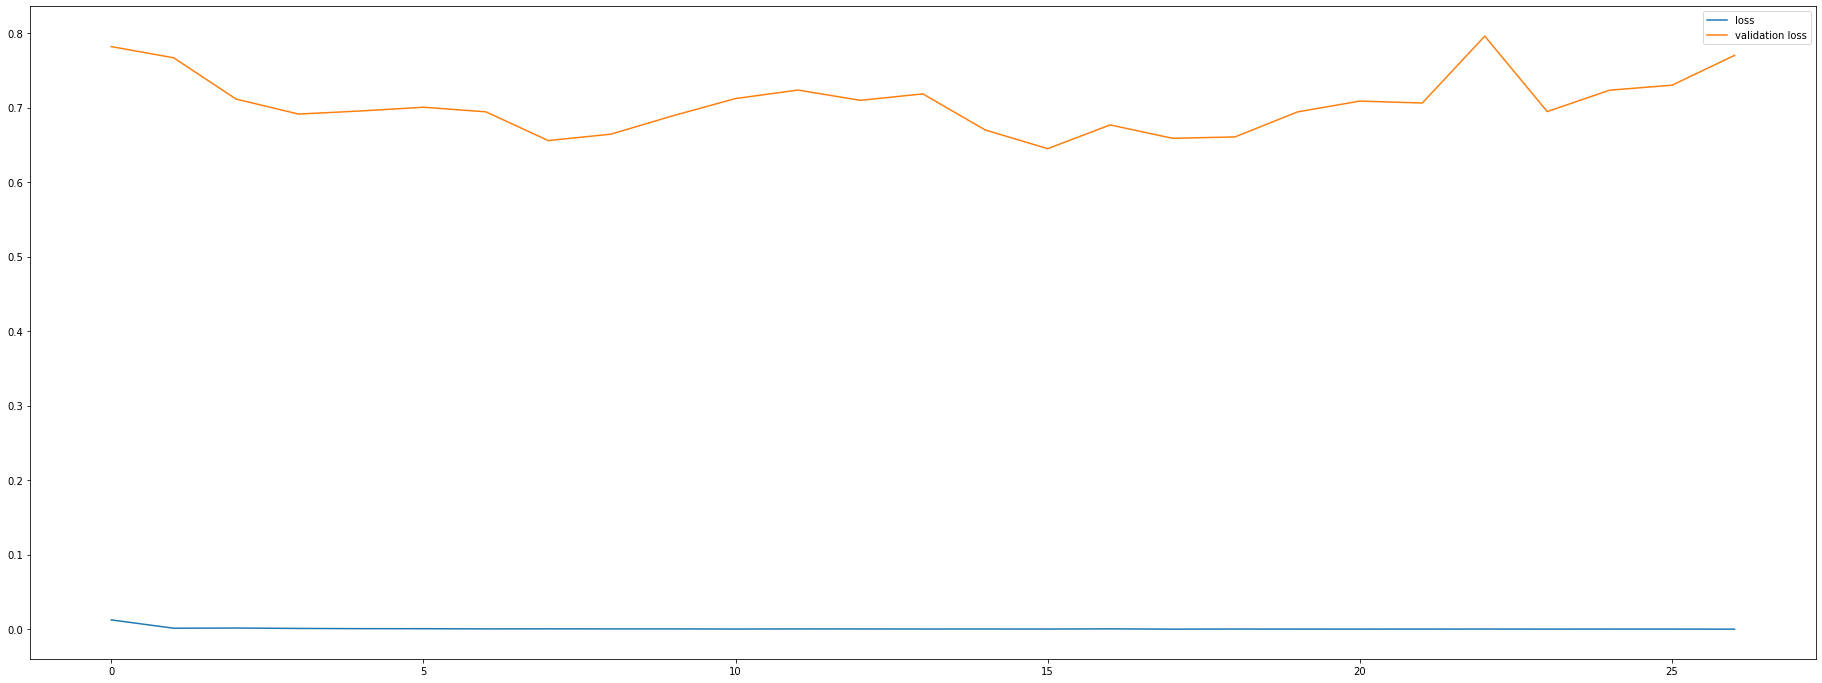

In [26]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="validation loss")
plt.legend()

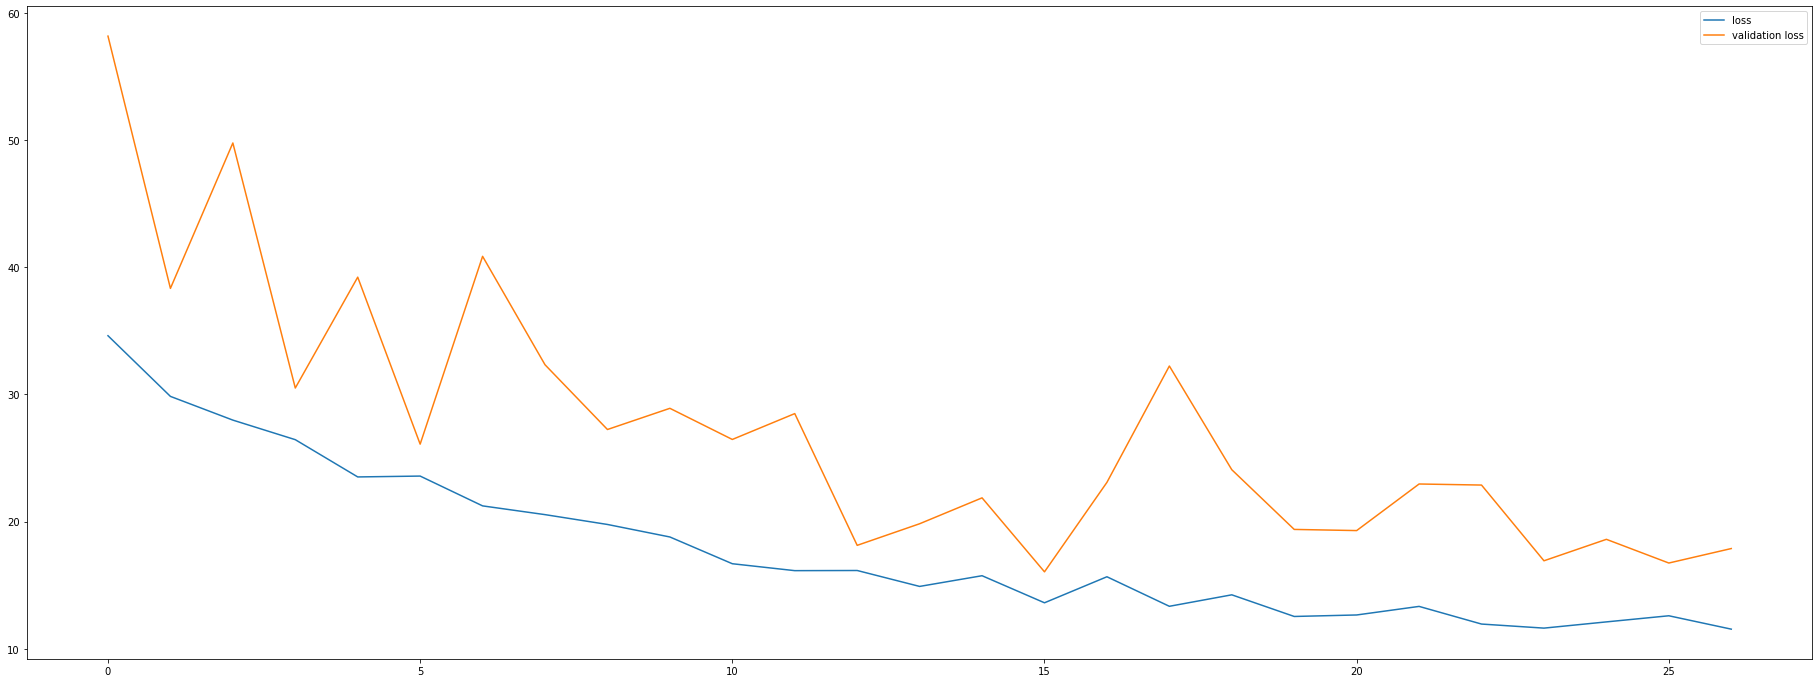

In [27]:
plt.plot(r.history["mape"], label="loss")
plt.plot(r.history["val_mape"], label="validation loss")
plt.legend()

In [ ]:
def test(countryList, plot = False):
  a = []
  for country in countryList:
    Xr = []
    Yr = []
    b = buildBorderData(NormalizedMovingAvgCumulativeCases, country)
    v = df[df["Country"] == country][NormalizedMovingAvgCumulativeCases].values
    cc = df[df["Country"] == country][NormalizedMovingAvgCumulativeCases].values
    t = df[df["Country"] == country]["TransmissionType"].values
    for i in range(0, len(v) - IntervalDays-PredictionTargetDay):
      x = v[i:i+IntervalDays]
      bbx = b[i:i+IntervalDays]
      tx = t[i:i+IntervalDays]
      x = np.array([x, bbx, tx]).T

      y = cc[i+IntervalDays+PredictionTargetDay]
      y = np.array(y)

      Xr.append(x)
      Yr.append(y)
      
    Xr = np.array(Xr).reshape(-1, IntervalDays, 3)
    Yr = np.array(Yr)
    Yp = model.predict(Xr)
    print(country, mean_absolute_percentage_error(Yr, Yp))
    a.append(mean_absolute_percentage_error(Yr, Yp))
    if plot:
      plt.plot(cumulativeScaler.inverse_transform(Yp), label='prediction_'+country)
      plt.plot(cumulativeScaler.inverse_transform(Yr), label='real_'+country)
      plt.legend()
  print(mean(a)*100, "AVERAGE MAPE")

In [36]:
test(test_country, False)

Brazil 0.12907132409299488
Thailand 0.002996081664965126
Malaysia 0.08650888762319735
Japan 0.08885699081337978
Republic of Korea 0.00755187312695859
6.299703146429915 AVERAGE MAPE


The United Kingdom 0.13885222314341475
13.885222314341474 AVERAGE MAPE


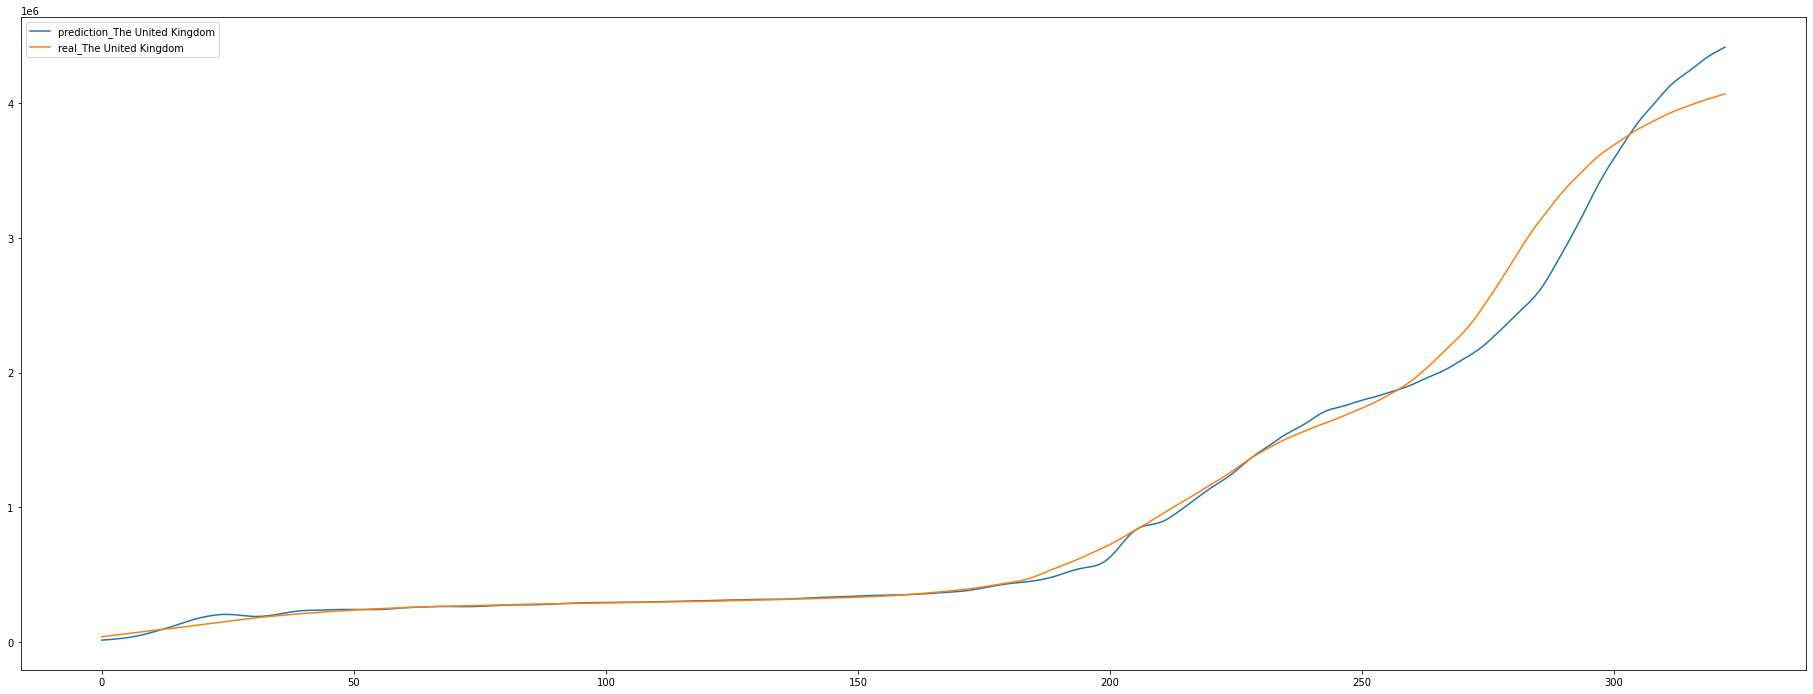

In [32]:
test(["The United Kingdom"], True)

Thailand 0.002996081664965126
0.2996081664965126 AVERAGE MAPE


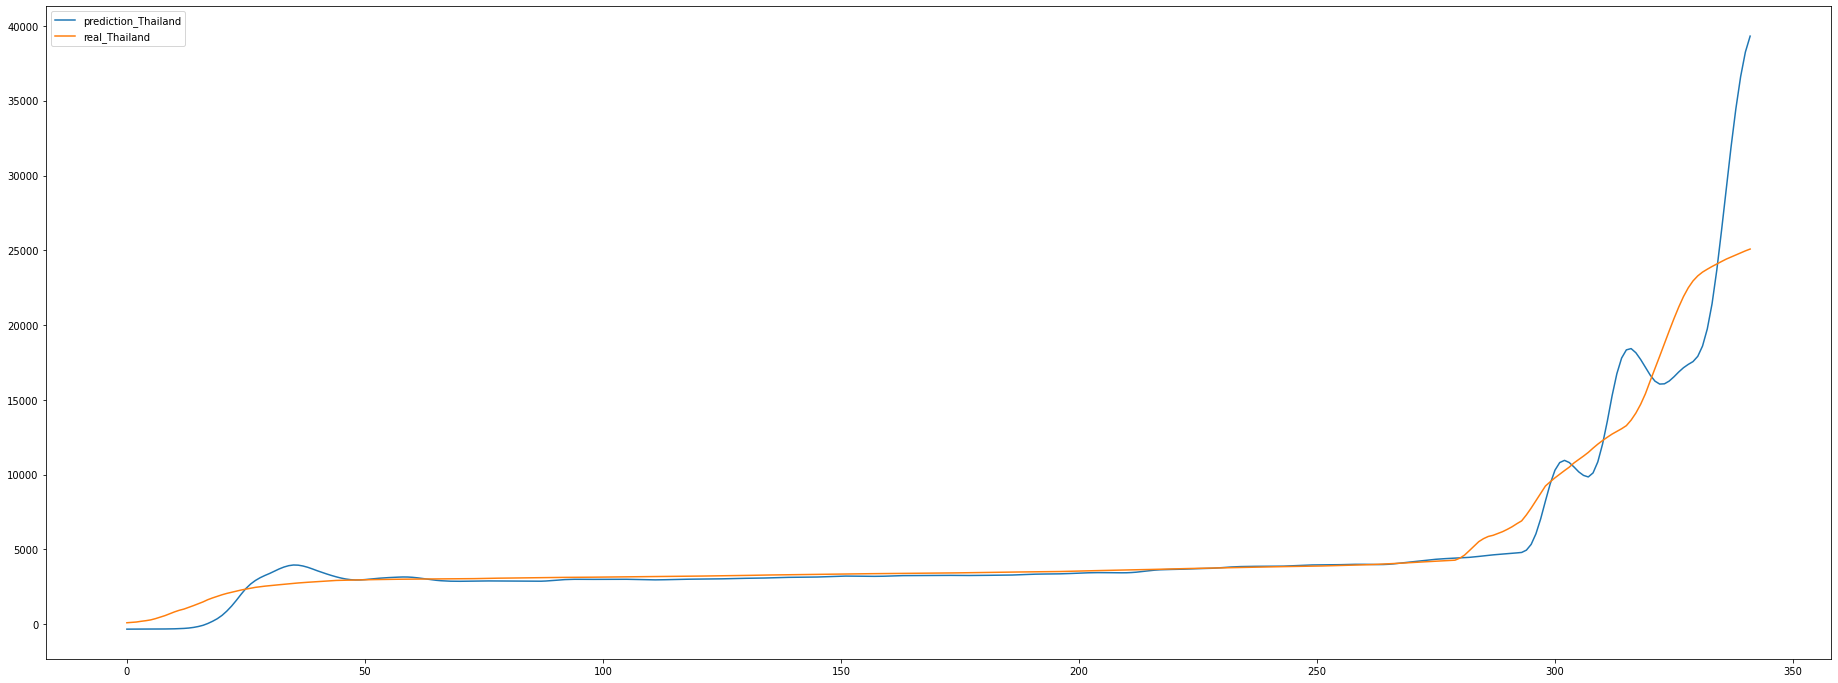

In [33]:
test(["Thailand"], True)